# Integrating PBMC data using SCALEX

The following tutorial demonstrates how to use SCALEX for *integrating* PBMC data. 

There are two parts of this tutorial:

* **Seeing the batch effect.** This part will show the batch effects of two PBMC datasets from single cell 3' and 5’ gene expression libraries that used in SCALEX manuscript.
* **Integrating data using SCALEX.** This part will show you how to perform batch correction using [SCALEX](https://scalex.readthedocs.io/en/latest/api/scalex.SCALEX.html#scalex.SCALEX) function in SCALEX.

In [1]:
import scalex
from scalex.function import SCALEX
from scalex.plot import embedding
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)
sc.logging.print_header()
plt.rcParams['axes.unicode_minus']=False

scanpy==1.6.1 anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
sns.__version__

'0.10.1'

In [4]:
scalex.__version__

'2.0.3.dev'

## Seeing the batch effect

The following data has been used in the [Seurat v2](https://www.nature.com/articles/nbt.4096) paper, has been used here, and can be downloaded from [here](http://zhanglab.net/scalex-tutorial/pbmc.h5ad).

On a unix system, you can uncomment and run the following to download the count matrix in its anndata format.

In [5]:
# ! wget http://zhanglab.net/scalex-tutorial/pbmc.h5ad

In [6]:
wk_dir='./' # wk_dir is your local path to store data and results

In [7]:
adata_raw=sc.read(wk_dir+'/pbmc.h5ad') # wk_dir is your local path to store data and results
adata_raw

AnnData object with n_obs × n_vars = 15476 × 33694
    obs: 'batch', 'celltype', 'protocol', 'celltype0'

Inspect the batches contained in the dataset.

In [8]:
adata_raw.obs.batch.value_counts()

pbmc_3p    8098
pbmc_5p    7378
Name: batch, dtype: int64

The data processing procedure is according to the scanpy tutorial [[Preprocessing and clustering 3k PBMCs]](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing-and-clustering-3k-PBMCs).

In [9]:
sc.pp.filter_cells(adata_raw, min_genes=600)
sc.pp.filter_genes(adata_raw, min_cells=3)
adata_raw = adata_raw[:, [gene for gene in adata_raw.var_names if not str(gene).startswith(tuple(['ERCC', 'MT-', 'mt-']))]]
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
sc.pp.highly_variable_genes(adata_raw, min_mean=0.0125, max_mean=3, min_disp=0.5)    
adata_raw.raw = adata_raw
adata_raw = adata_raw[:, adata_raw.var.highly_variable]
sc.pp.scale(adata_raw, max_value=10)
sc.pp.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.umap(adata_raw)

filtered out 13316 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


We observe a batch effect.

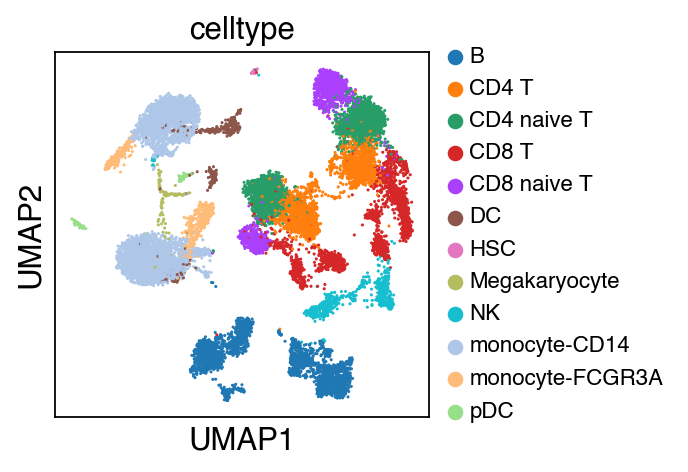

In [10]:
sc.pl.umap(adata_raw,color=['celltype'],legend_fontsize=10)

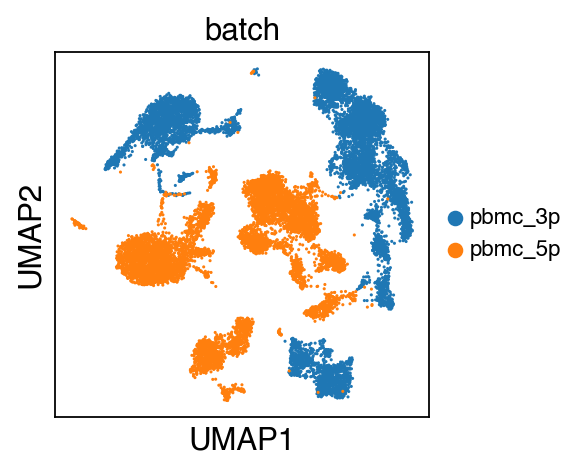

In [11]:
sc.pl.umap(adata_raw,color=['batch'],legend_fontsize=10)

In [12]:
adata_raw

AnnData object with n_obs × n_vars = 15476 × 1125
    obs: 'batch', 'celltype', 'protocol', 'celltype0', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Integrating data using SCALEX

The batch effects can be well-resolved using SCALEX.

<div class="alert alert-info">

**Note**

Here we use GPU to speed up the calculation process, however, you can get the same level of performance only using cpu.    

</div>  

In [13]:
adata=SCALEX(wk_dir+'pbmc.h5ad',batch_name='batch',min_features=600, min_cells=3, outdir=wk_dir+'/pbmc_output/',show=False,gpu=9)

2021-03-25 12:38:57,568 - root - INFO - Raw dataset shape: (15476, 33694)
2021-03-25 12:38:57,569 - root - INFO - Preprocessing
2021-03-25 12:38:57,606 - root - INFO - Filtering cells
Trying to set attribute `.obs` of view, copying.
2021-03-25 12:38:58,674 - root - INFO - Filtering features


filtered out 13316 genes that are detected in less than 3 cells


2021-03-25 12:38:59,276 - root - INFO - Normalizing total per cell


normalizing counts per cell
    finished (0:00:00)


2021-03-25 12:38:59,419 - root - INFO - Log1p transforming
2021-03-25 12:38:59,892 - root - INFO - Finding variable features


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


2021-03-25 12:39:02,736 - root - INFO - Batch specific maxabs scaling
2021-03-25 12:39:04,374 - root - INFO - Processed dataset shape: (15476, 2000)
2021-03-25 12:39:04,398 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=2000, out_features=1024, bias=True)
          (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
      )
    )
    (mu_enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=1024, out_features=10, bias=True)
        )
      )
    )
    (var_enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=1024, out_features=10, bias=True)
        )
      )
    )
  )
  (decoder): NN(
    (net): ModuleList(
      (0): Block(
        (fc): Linear(in_features=10, out_features=2000, bias=True)
        (norm): DSBatchNorm(
          (bns): ModuleList(

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


In [14]:
adata

AnnData object with n_obs × n_vars = 15476 × 2000
    obs: 'batch', 'celltype', 'protocol', 'celltype0', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'leiden', 'batch_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

While there seems to be some strong batch-effect in all cell types, SCALEX can integrate them homogeneously.

In [15]:
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)

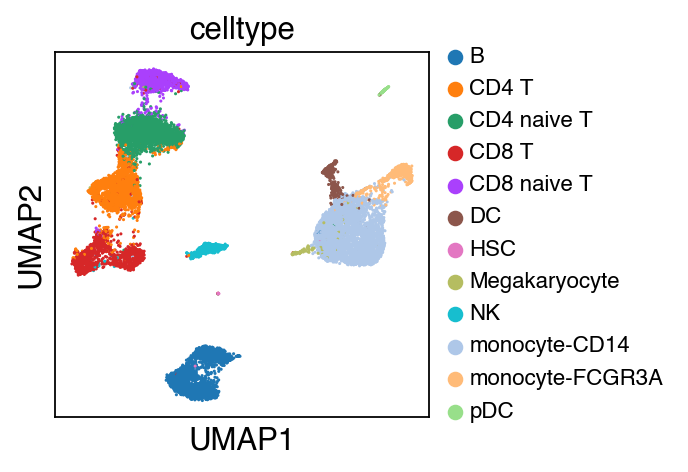

In [16]:
sc.pl.umap(adata,color=['celltype'],legend_fontsize=10)

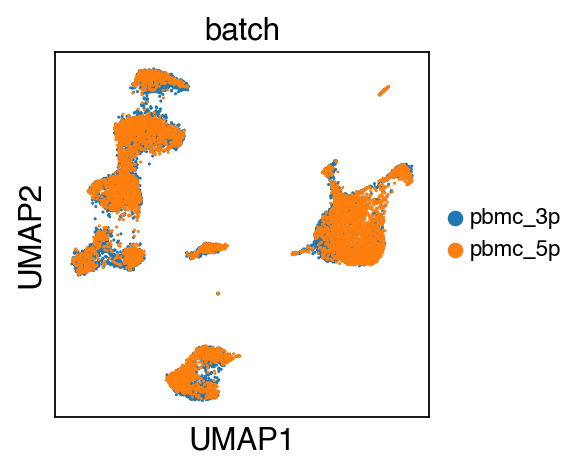

In [17]:
sc.pl.umap(adata,color=['batch'],legend_fontsize=10)

The integrated data is stored as `adata.h5ad` in the output directory assigned by `outdir` parameter in [SCALEX](https://scalex.readthedocs.io/en/latest/api/scale.SCALEX.html#scalex.SCALEX) function. 